<h1><center> Gesture detection and classification to detect confusion using MediaPipe, Locally Linear Embedding and KMeans clustering. </center></h1>

## Importing the required libraries

In [1]:
import mediapipe as mp
import cv2
import matplotlib.pyplot as plt
import glob
import math
import numpy as np
import seaborn as sns
sns.set()
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

<h1><center> Step 1: Pre-processing </center></h1>

## Part 1: Function to get joints' coodinates from an image 

In [2]:
def get_ten_joints(image):
#     image = cv2.imread(image)
    image_vector = []
    mp_pose = mp.solutions.pose
    # Initialize MediaPipe Pose.
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)
#     print(pose)
    mp_drawing = mp.solutions.drawing_utils 
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     results = pose.process(image)
#     print('results = ', results.pose_landmarks)
    # Print nose landmark.
    image_hight, image_width, image_depth = image.shape
    #     if not results.pose_landmarks:
    #         continue
#     print(results.pose_landmarks)
# asjdnaisdbasdhbhkasbkahdbasidhan akjnfbqiu
    if(results.pose_landmarks is None ):
        return ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    
    left_shoulder = (results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * image_width, 
                 results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * image_hight)
    #     print("Left Shoulder Location : ", left_shoulder)
    right_shoulder = (results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * image_width,
                  results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * image_hight)
    #     print("Right Shoulder Location : ", right_shoulder)
    nose_cood = (results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width,
                 results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_hight,
                 results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].z * image_depth)
    
    #     print("Nose Location : ", nose_cood)

    # Creating a centroid (point between nose and shoulders as the new origin (0,0))
    
    centroid = ((left_shoulder[0] + right_shoulder[0] + nose_cood[0]) / 3 , (left_shoulder[1] + right_shoulder[1] + nose_cood[1]) / 3)
    #     print("Centroid = ", centroid)
    
    centroid_point = (int(centroid[0]), int(centroid[1]))
    cv2.circle(image, centroid_point, 3, (255,0,0), -1)
    
    # Calculating the point for head/face and replacing the values in the landmakrs 
    
    left_ear = (results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].x * image_width, 
               results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR].y * image_hight)
    right_ear = (results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EAR].x * image_width, 
                 results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EAR].y * image_hight)
# Now we have to replace the values from loc 0(nose) to loc 10 (right mouth) and put a general point for head which is mid
# point of 2 ears
    
    head = ((left_ear[0] + right_ear[0]) / 2, (left_ear[1] + right_ear[1]) / 2)
#     print("Head = ", head)
    head_point = (int(head[0]), int(head[1]))
    cv2.circle(image, head_point, 3, (0,0,255), -1)
    
# Updating removing the 10 points and putting 1 head point 
    allJointsXarray = []
    allJointsYarray = []
    
    for i in mp_pose.PoseLandmark:
        allJointsXarray.append((results.pose_landmarks.landmark[i].x) * image_width)
        allJointsYarray.append((results.pose_landmarks.landmark[i].y) * image_hight)
    
    tenJointsXArray = allJointsXarray[11:25]
    tenJointsYArray = allJointsYarray[11:25]
    tenJointsXArray.insert(0, head[0])
    tenJointsYArray.insert(0, head[1])
    tenJointsXArray.insert(1, centroid[0])
    tenJointsYArray.insert(1, centroid[1])

# Removing the unnecessary points
    for i in range(6):
        del tenJointsXArray[6]
    for i in range(6):
        del tenJointsYArray[6]
    
# Redifining points wrt to new centroid   
    xCoordinatesCentroid = list(map(lambda x: x - centroid[0], tenJointsXArray))
    yCoordinatesCentroid = list(map(lambda y: y - centroid[1], tenJointsYArray))
    

    
    
    current_vector = []
    for i in range(len(xCoordinatesCentroid)):
        current_vector.append((xCoordinatesCentroid[i], yCoordinatesCentroid[i]))
    image_vector.append(current_vector)
    
    
    
    
    
    
# Drawing a rectangle around the min and max point of the image. 
    rectBottomLeft = (math.floor(min(tenJointsXArray)), math.floor(min(tenJointsYArray)))
    rectTopRight = (math.ceil(max(tenJointsXArray)), math.ceil(max(tenJointsYArray)))
   
    

    cv2.circle(image, rectBottomLeft, 3, (0,0,255), -1)
    cv2.circle(image, rectTopRight, 3, (0,0,255), -1)
    cv2.rectangle(image, rectBottomLeft, rectTopRight, (255,0,0), 1)
    
# Draw pose landmarks.
#     print(f'Pose landmarks of {name}:')
#     annotated_image = image.copy()
#     mp_drawing.draw_landmarks(
#       image=annotated_image,
#       landmark_list=results.pose_landmarks,
#       connections=mp_pose.POSE_CONNECTIONS,
#       landmark_drawing_spec=drawing_spec,
#       connection_drawing_spec=drawing_spec)
#     cv2.imshow('annotated_iamge', annotated_image)
#     plt.figure()
#     plt.imshow(annotated_image)
#     cv2.waitKey(0)
#     newXArray = list(map(lambda x: x - centroid[0], xArray))
#     newYArray = list(map(lambda y: y - centroid[1], yArray))
#     head_plotX = [newXArray[0], newXArray[1]]
#     head_plotY = [newYArray[0], newYArray[1]]
#     hands_plotX = [newXArray[6], newXArray[4], newXArray[2],newXArray[3],newXArray[5],newXArray[7]]
#     hands_plotY = [newYArray[6], newYArray[4], newYArray[2],newYArray[3],newYArray[5],newYArray[7]]
#     body_plotX = [newXArray[2], newXArray[8], newXArray[9], newXArray[3]]
#     body_plotY = [newYArray[2], newYArray[8], newYArray[9], newYArray[3]]
#     plt.plot(head_plotX, head_plotY, 'o', color='black' , linewidth=1, linestyle='solid')
#     plt.plot(hands_plotX, hands_plotY, 'o', color='black', linewidth=1, linestyle='solid')
#     plt.plot(body_plotX, body_plotY, 'o', color='black', linewidth=1, linestyle='solid')
#     plt.yscale("linear")
#     plt.ylim(max(newYArray) + 20, min(newYArray) - 20)
#     plt.xlim(-300, 300)
#     plt.show()
#     plt.imshow(annotated_image)
   
    final = []
    for i in image_vector:
        height = int(abs(i[-2][1] - i[2][1]))
        width = int(abs(i[3][0] - i[2][0]))
#         print(height, width)

        y = 150 / height
        x = 50 / width

        ratio = (y, x)
        temp = list()
        for j in i:
            temp.append((j[0] * x, j[1] * y))
        final.append(temp)
    
    normalizedXarray = list()
    normalizedYarray = list()
    
    for z in final:
        xList = []
        yList = []
        for x, y in z:
            xList.append(x)
            yList.append(y)
        normalizedXarray = xList
        normalizedYarray = yList
    
#     plt.figure(figsize=(10,10))
    newXArray = normalizedXarray
    newYArray = normalizedYarray
#     for i in range(len(image_vector)):
#         head_plotX = [normalizedXarray[0], normalizedXarray[1]]
#         head_plotY = [normalizedYarray[0], normalizedYarray[1]]
#         hands_plotX = [normalizedXarray[6], normalizedXarray[4], normalizedXarray[2],normalizedXarray[3],normalizedXarray[5],normalizedXarray[7]]
#         hands_plotY = [normalizedYarray[6], normalizedYarray[4], normalizedYarray[2],normalizedYarray[3],normalizedYarray[5],normalizedYarray[7]]
#         body_plotX = [normalizedXarray[2], normalizedXarray[8], normalizedXarray[9], normalizedXarray[3]]
#         body_plotY = [normalizedYarray[2], normalizedYarray[8], normalizedYarray[9], normalizedYarray[3]]
#         plt.plot(head_plotX, head_plotY, 'o', color='black', linewidth=1, linestyle='solid', label=i)
#         plt.plot(hands_plotX, hands_plotY, 'o', color='black', linewidth=1, linestyle='solid')
#         plt.plot(body_plotX, body_plotY, 'o', color='black', linewidth=1, linestyle='solid')
#     plt.gca().invert_yaxis()
#     plt.legend(loc='best')
#     plt.show()
    
    return (normalizedXarray, normalizedYarray)

### Testing the get_ten_joints function

In [3]:
images = {name: cv2.imread(name) for name in glob.glob('./Images\confused/mixedsamples/*jpg')}

for name, image in images.items():
#     plt.figure()
#     plt.imshow(image)
    print(name)   
#     cv2.imshow('image',image)
#     cv2.waitKey(0)
    normalized_X_coordinates, normalized_Y_coordinates = get_ten_joints(image)
    print("normalized_X_coordinates = ", normalized_X_coordinates)
    print("normalized_Y_coordinates = ", normalized_Y_coordinates)

./Images\confused/mixedsamples\chin (1).jpg
normalized_X_coordinates =  [-3.359994141662374, 0.0, 28.26364443023154, -21.80330915019867, 39.93959417368503, -23.860618123348722, -5.954259737057889, -5.906477855875137, 23.32287419666635, -11.214934257750816]
normalized_Y_coordinates =  [-52.12860262912253, 0.0, 24.581267664083846, 27.48169328855431, 133.94079542913926, 128.88124455576357, 101.65123953649649, 9.987417888264405, 175.15440349993497, 176.840413936042]
./Images\confused/mixedsamples\chin (2).jpg
normalized_X_coordinates =  [-1.6482894308865073, 0.0, 25.478429091162983, -24.966619908809662, 30.248492606915537, -24.946913495659828, -12.149062869139016, -7.343390840105713, 14.65752145741135, -17.035572067834437]
normalized_Y_coordinates =  [-49.350560162247724, 0.0, 20.58595529123515, 19.555829853570767, 126.79196325670772, 115.24146845360764, 102.44679425944801, -5.459656084285057, 170.6611491051041, 167.71936086045596]
./Images\confused/mixedsamples\chin (3).jpg
normalized_X_c

normalized_X_coordinates =  [-0.9889931869095386, 0.0, 25.047392778283434, -25.073433128118264, 40.58213630026083, -40.20452242195928, 34.94448286301366, -35.45481693140255, 17.42056606914104, -12.859204569037813]
normalized_Y_coordinates =  [-43.29092860221863, 0.0, 15.769205689430237, 20.76162278652191, 88.32712233066559, 97.0665317773819, 170.41314661502838, 169.11242544651031, 166.1062377691269, 169.17374074459076]
./Images\confused/mixedsamples\frame6300.jpg
normalized_X_coordinates =  [-3.4264978805890802, 0.0, 26.16481115384797, -23.92412637832219, 50.92674099294432, -38.14506301237214, 40.20421915249418, -38.587609209595456, 19.530005977185347, -14.181086589569931]
normalized_Y_coordinates =  [-45.459820378211234, 0.0, 13.94166100409723, 21.09256867439516, 103.55596003993864, 120.02782091017691, 33.5582475508413, 44.18389643392255, 164.04693741952218, 164.04223057531541]
./Images\confused/mixedsamples\frame6450.jpg
normalized_X_coordinates =  [-4.147227548619607, 0.0, 27.450106

## Part 2: Function to get frames from a video on which we will use the created fucntion to obtain the coordinates of the joints 

In [4]:
# import cv2
# import os
# cap = cv2.VideoCapture('sampleOP.mp4')
# count = 0
# path = './Images\sampleOP'
# fps = cap.get(cv2.CAP_PROP_FPS)
# print(fps)
# while cap.isOpened():
#     ret, frame = cap.read()

#     if ret:
#         cv2.imwrite(os.path.join(path, 'frame{:d}.jpg'.format(count)), frame)
#         count += 150 # i.e. at 30 fps, this advances one second
#         cap.set(1, count)
#     else:
#         cap.release()
#         break

### We store the images at above 'path' and we run the function for each image 

In [5]:
images = {name: cv2.imread(name) for name in glob.glob('./Images\confused/mixedsamples/*jpg')}
LLEVideoArray = []
for name, image in images.items():
#     plt.figure()
#     plt.imshow(image)
    print(name)   
#     cv2.imshow('image',image)
#     cv2.waitKey(0)s
    normalized_X_coordinates, normalized_Y_coordinates = get_ten_joints(image)
    print("normalized_X_coordinates = ", normalized_X_coordinates)
    print("normalized_Y_coordinates = ", normalized_Y_coordinates)
    LLEVideoArray.append([normalized_X_coordinates, normalized_Y_coordinates])

./Images\confused/mixedsamples\chin (1).jpg
normalized_X_coordinates =  [-3.359994141662374, 0.0, 28.26364443023154, -21.80330915019867, 39.93959417368503, -23.860618123348722, -5.954259737057889, -5.906477855875137, 23.32287419666635, -11.214934257750816]
normalized_Y_coordinates =  [-52.12860262912253, 0.0, 24.581267664083846, 27.48169328855431, 133.94079542913926, 128.88124455576357, 101.65123953649649, 9.987417888264405, 175.15440349993497, 176.840413936042]
./Images\confused/mixedsamples\chin (2).jpg
normalized_X_coordinates =  [-1.6482894308865073, 0.0, 25.478429091162983, -24.966619908809662, 30.248492606915537, -24.946913495659828, -12.149062869139016, -7.343390840105713, 14.65752145741135, -17.035572067834437]
normalized_Y_coordinates =  [-49.350560162247724, 0.0, 20.58595529123515, 19.555829853570767, 126.79196325670772, 115.24146845360764, 102.44679425944801, -5.459656084285057, 170.6611491051041, 167.71936086045596]
./Images\confused/mixedsamples\chin (3).jpg
normalized_X_c

normalized_X_coordinates =  [-0.9889931869095386, 0.0, 25.047392778283434, -25.073433128118264, 40.58213630026083, -40.20452242195928, 34.94448286301366, -35.45481693140255, 17.42056606914104, -12.859204569037813]
normalized_Y_coordinates =  [-43.29092860221863, 0.0, 15.769205689430237, 20.76162278652191, 88.32712233066559, 97.0665317773819, 170.41314661502838, 169.11242544651031, 166.1062377691269, 169.17374074459076]
./Images\confused/mixedsamples\frame6300.jpg
normalized_X_coordinates =  [-3.4264978805890802, 0.0, 26.16481115384797, -23.92412637832219, 50.92674099294432, -38.14506301237214, 40.20421915249418, -38.587609209595456, 19.530005977185347, -14.181086589569931]
normalized_Y_coordinates =  [-45.459820378211234, 0.0, 13.94166100409723, 21.09256867439516, 103.55596003993864, 120.02782091017691, 33.5582475508413, 44.18389643392255, 164.04693741952218, 164.04223057531541]
./Images\confused/mixedsamples\frame6450.jpg
normalized_X_coordinates =  [-4.147227548619607, 0.0, 27.450106

<h1><center> Step 2: Generate an input for LLE model 

In [6]:
LLEFrames = []
for k in range(len(LLEVideoArray)):
    temp = []
    for i in range(len(LLEVideoArray[k][0])):
        temp.append(LLEVideoArray[k][0][i])
        temp.append(LLEVideoArray[k][1][i])           
    LLEFrames.append(temp)
print(LLEFrames)

[[-3.359994141662374, -52.12860262912253, 0.0, 0.0, 28.26364443023154, 24.581267664083846, -21.80330915019867, 27.48169328855431, 39.93959417368503, 133.94079542913926, -23.860618123348722, 128.88124455576357, -5.954259737057889, 101.65123953649649, -5.906477855875137, 9.987417888264405, 23.32287419666635, 175.15440349993497, -11.214934257750816, 176.840413936042], [-1.6482894308865073, -49.350560162247724, 0.0, 0.0, 25.478429091162983, 20.58595529123515, -24.966619908809662, 19.555829853570767, 30.248492606915537, 126.79196325670772, -24.946913495659828, 115.24146845360764, -12.149062869139016, 102.44679425944801, -7.343390840105713, -5.459656084285057, 14.65752145741135, 170.6611491051041, -17.035572067834437, 167.71936086045596], [-0.24794960158995483, -46.313237457375266, 0.0, 0.0, 25.125425094845646, 20.338835891004628, -25.1131344800708, 19.422016780413877, 35.09058897522674, 120.64250907348713, -24.164784811008943, 110.4815274633038, -1.098772712137514, 119.7927418179537, 1.5031

<h1><center> Step 3: Using the LLE model to see the difference between gestures 

In [7]:
from sklearn import manifold, datasets
LLEReduced, err = manifold.locally_linear_embedding(LLEFrames, n_neighbors=20, n_components=2)
print("Done. Reconstruction error: %g" % err)
images = {name: cv2.imread(name) for name in glob.glob('./Images\confused/mixedsamples/*jpg')}
imageNames = [name for name, image in images.items()]
imagesArray = [np.array(cv2.imread(name)) for name, image in images.items()]
names = []
# for i in imageNames:
#     print(name)
#     names.append(i.split("\\")[-1])
#     print(imageNames)

Done. Reconstruction error: 0.000137464


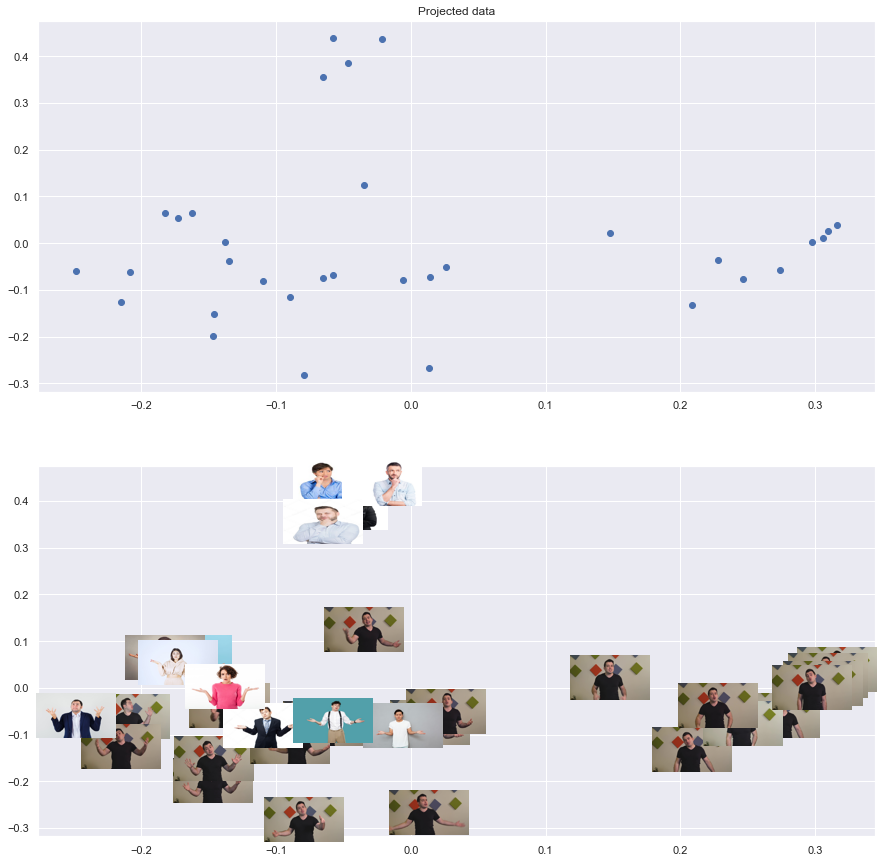

In [8]:
# Plot result
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import plotly.express as px

fig = plt.figure(figsize=(15,15))



# ax = fig.add_subplot(211, projection='3d')
# ax.scatter(X[:, 0], X[:, 1], X[:,1])

# ax.set_title("Original data")

def getImage(path):
    im = Image.open(path)
#     (width, height) = (im.width // 10, im.height // 10)
    (width, height) = (80, 45)
    im_res = im.resize((width, height))
    return OffsetImage(im_res)


ax = fig.add_subplot(212)
# ax.margins(0.05) 
# plt.figure(figsize=(30,30))
plt.scatter(LLEReduced[:, 0], LLEReduced[:, 1])
# plt.xlim([-0.5, 0.5])
# plt.ylim([-0.5, 0.5])
# for i, txt in enumerate(names):
#     plt.annotate(txt, (LLEReduced[i, 0] + 0.005, LLEReduced[i, 1] + 0.005), fontsize=12)
# for x0, y0, path in zip(annotateX, annotateY, imageNames):
#     ab = AnnotationBbox(getImage(path), (x0,y0), frameon=False)
#     ax.add_artist(ab)
    
for i, path in zip(range(len(LLEReduced)), imageNames):
    ab = AnnotationBbox(getImage(path), (LLEReduced[i, 0], LLEReduced[i, 1]), frameon=False)
    ax.add_artist(ab)
    
ax = fig.add_subplot(211)

# ax.margins(0.05) 
# plt.figure(figsize=(30,30))
plt.scatter(LLEReduced[:, 0], LLEReduced[:, 1])
# plt.xlim([-0.5, 0.5])
# plt.ylim([-0.5, 0.5])
plt.axis('tight')
# plt.xticks([]), plt.yticks([])
plt.title('Projected data')
plt.show()
# annotate

# K means cluster

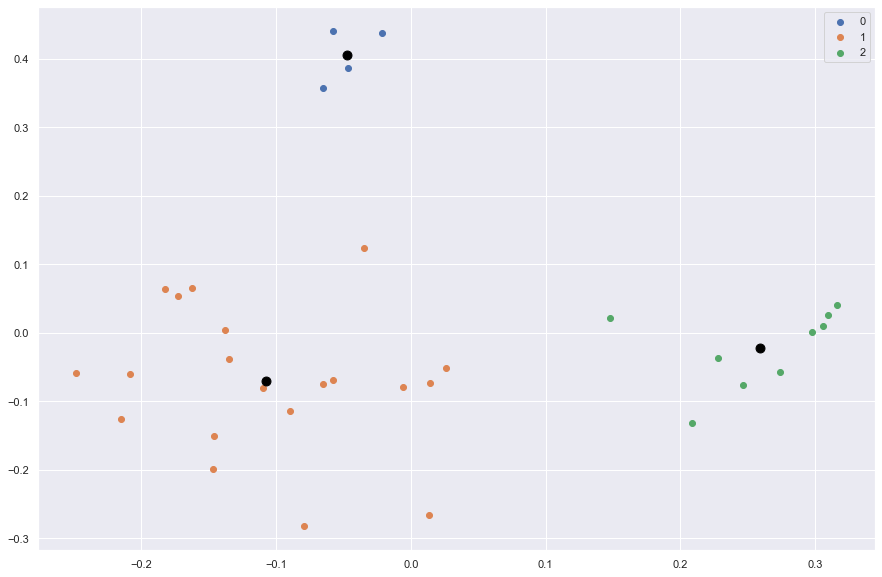

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 3, random_state=0)

#predict the labels of clusters.
label = kmeans.fit_predict(LLEReduced)
 
#Getting unique labels
u_labels = np.unique(label)
centroids = kmeans.cluster_centers_

#plotting the results:
plt.figure(figsize=(15,10))
# plt.xlim([-0.5, 0.5])
# plt.ylim([-0.5, 0.5])
for i in u_labels:
    plt.scatter(LLEReduced[label == i , 0] , LLEReduced[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'black')
plt.legend()
plt.show()

# Testing the KMeans Model for a new image

./Images\imtestsamples\cs 1.jpg
normalized_X_coordinates =  [-2.1858955782968605, 0.0, 27.500753392631886, -22.600116022830996, 16.28458656118688, -26.40086809074245, -29.70065918665577, -12.019235190849946, 11.43049969909272, -21.388297704394887]
normalized_Y_coordinates =  [-52.46816361634925, 0.0, 28.290430652467826, 22.08839301287272, 134.63307309664037, 116.29678180628416, 112.48251708785882, 2.004064911860598, 178.85547113475616, 173.43097059635454]
./Images\imtestsamples\cs 10.jpg
normalized_X_coordinates =  [-2.616034491395573, 0.0, 26.734998955890184, -23.393187485143816, 30.303009267218194, -24.215707992815407, -10.892548315757812, -6.986289508739059, 19.37050696727783, -11.664196495015892]
normalized_Y_coordinates =  [-49.26337974686776, 0.0, 19.733015087343038, 20.594980447523064, 138.53195165434192, 124.75530418657489, 121.46208795808978, 0.305831432342535, 169.99726574267115, 172.27432564381633]
./Images\imtestsamples\cs 11.jpg
normalized_X_coordinates =  [-0.167594203615

normalized_X_coordinates =  [0.5632554161689317, 0.0, 24.242791146655357, -25.797752987670332, 30.669082353952014, -34.35632021202098, 22.843416848365543, -33.1407366249062, 7.782616560789692, -20.2311350093127]
normalized_Y_coordinates =  [-43.91535802418927, 0.0, 23.855704769312627, 17.48819038810501, 94.52186883932137, 89.87646998770266, 168.43493713671904, 163.74621495424984, 173.92322421073914, 170.60551478202086]
./Images\imtestsamples\idle 4.jpg
normalized_X_coordinates =  [1.7446408065867933, 0.0, 24.05213671818114, -25.95020933994237, 32.85609690444833, -38.07724727149274, 12.975674135643136, -23.34309100461232, 9.776384643858417, -17.483780339018377]
normalized_Y_coordinates =  [-44.39086132291435, 0.0, 24.108843095060703, 15.584267135979468, 106.10637111940245, 92.4134764118471, 166.63728503213412, 159.62144646091735, 174.29654408192286, 173.07083287100858]
./Images\imtestsamples\idle 5.jpg
normalized_X_coordinates =  [-0.4403340094017293, 0.0, 25.832323775146943, -24.214560

<ipython-input-10-591dfff28096>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


normalized_X_coordinates =  [1.924855256071071, 0.0, 24.02288389798158, -26.006810319347263, 33.993060404482556, -32.94022999799405, 20.05386049262224, -21.116624194651084, 12.433225752260435, -15.703722091917049]
normalized_Y_coordinates =  [-44.06556674519426, 0.0, 21.661106239324837, 19.729510886864084, 98.9125481566543, 99.0465039727073, 172.37614723121595, 177.02103317158776, 171.81821120610027, 173.1879231314989]
./Images\imtestsamples\idle 7.jpg
normalized_X_coordinates =  [-5.645748132314437, 0.0, 29.968485618248963, -20.334590704013138, 40.64623361978775, -33.470743741744606, 33.359737732471565, -25.66452973928207, 18.15196795341296, -10.529695413051506]
normalized_Y_coordinates =  [-39.00822188006714, 0.0, 9.16555153671652, 22.825630707666278, 78.57757781166583, 83.35034160409123, 160.71212401147932, 165.54788073990494, 159.34698942583054, 159.91013199090958]
./Images\imtestsamples\idle 8.jpg
normalized_X_coordinates =  [0.08428443241589176, 0.0, 25.431405719865133, -24.76060

./Images\imtestsamples\shrug 5.jpg
normalized_X_coordinates =  [-0.3434653234000122, 0.0, 24.961201831547903, -25.093891644718667, 44.82028460261798, -40.014051186918, 62.77700096669823, -62.23989929815735, 19.237109868213388, -13.480016920301646]
normalized_Y_coordinates =  [-44.549900672193296, 0.0, 14.364927047390049, 20.242350131778394, 103.57365759752564, 115.10094783063661, 17.92145528025546, 30.788157905562446, 164.77216613494744, 166.3364990787991]
./Images\imtestsamples\shrug 6.jpg
normalized_X_coordinates =  [-2.985406398308434, 0.0, 26.473431588381125, -23.62253256940934, 41.309300425224606, -31.690126245017165, 62.18460553686986, -51.68679179387715, 16.622497876252815, -15.86493968847434]
normalized_Y_coordinates =  [-46.43320902204418, 0.0, 14.401655618997506, 27.764714427781158, 100.1289433560836, 121.100463971466, 16.45221041874668, 7.55748950226407, 164.47506851514814, 165.5496331142858]
./Images\imtestsamples\shrug 7.jpg
normalized_X_coordinates =  [-0.6310603237085495

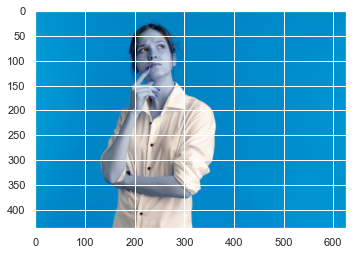

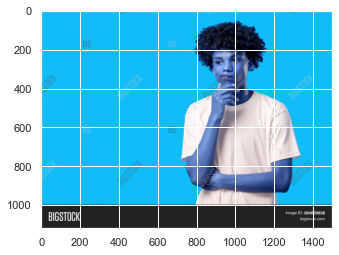

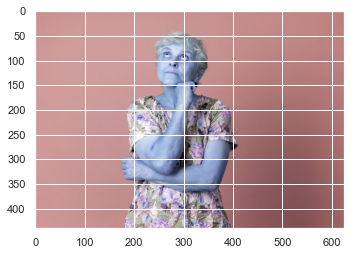

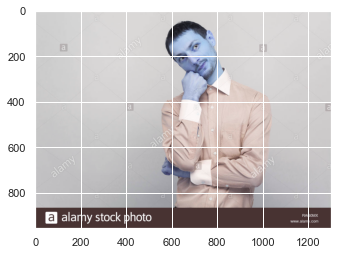

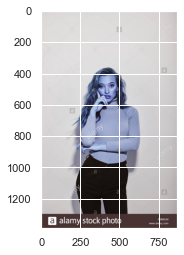

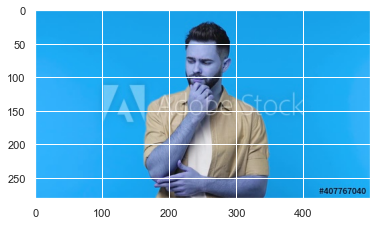

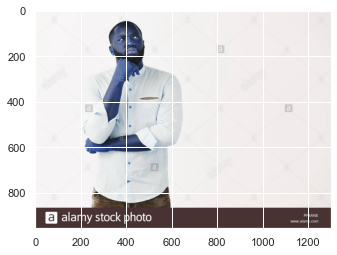

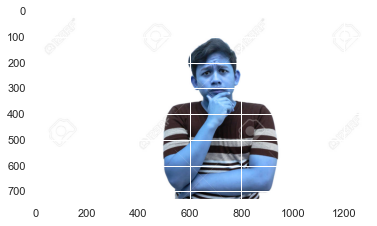

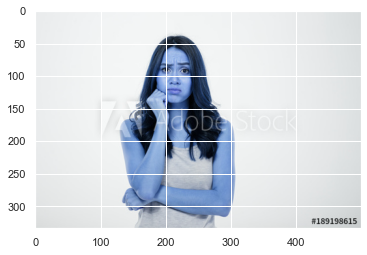

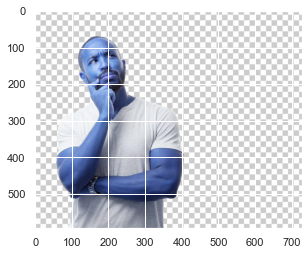

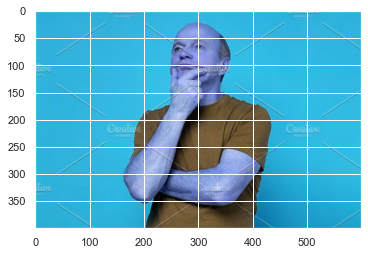

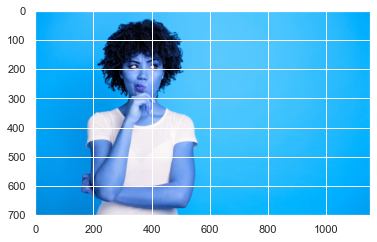

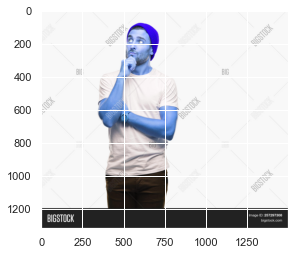

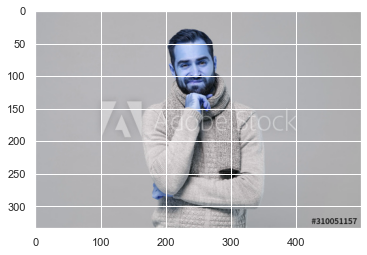

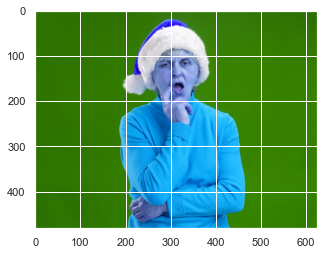

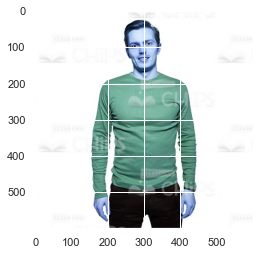

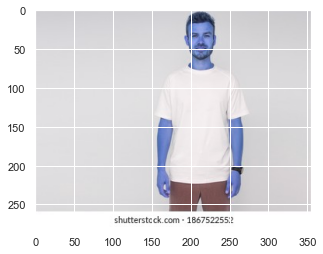

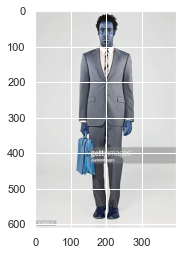

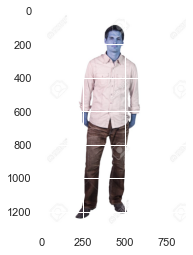

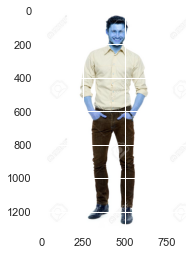

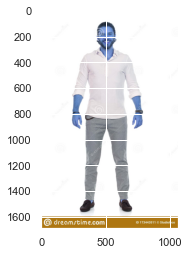

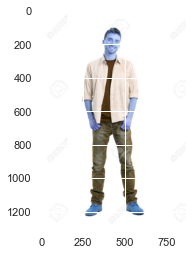

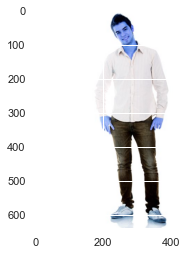

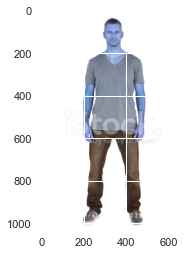

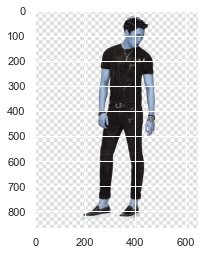

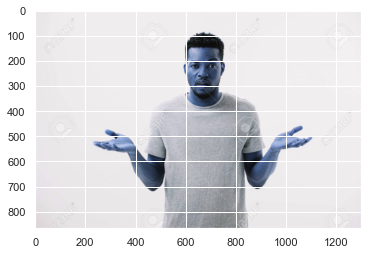

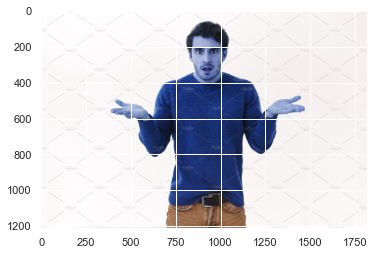

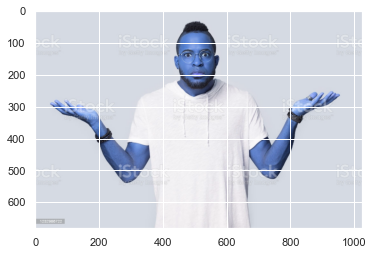

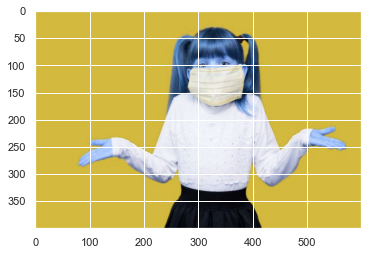

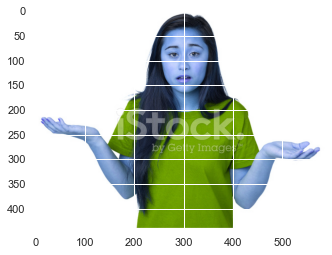

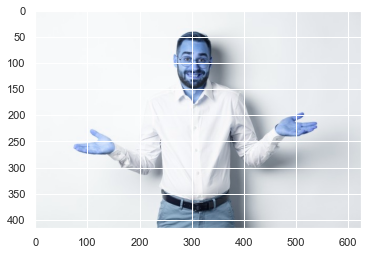

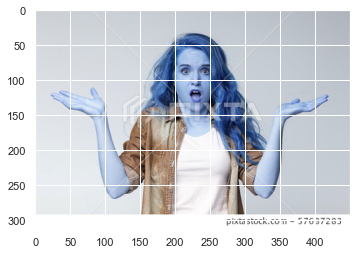

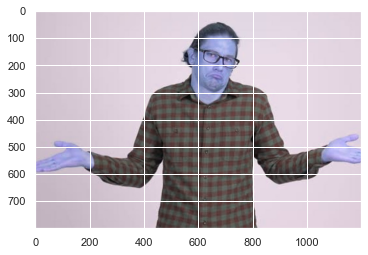

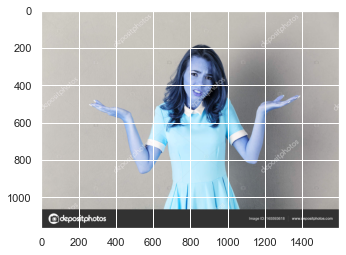

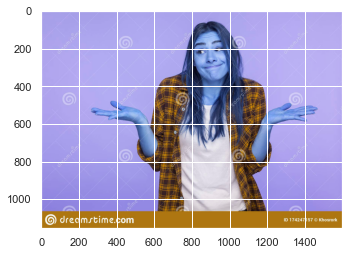

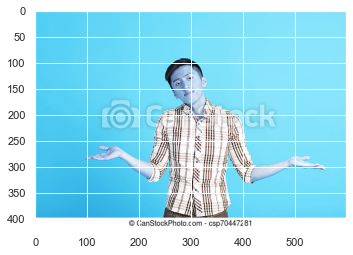

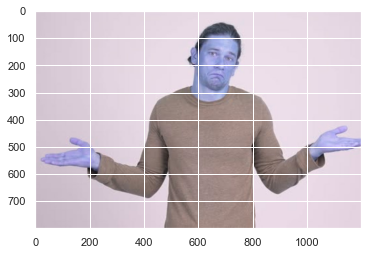

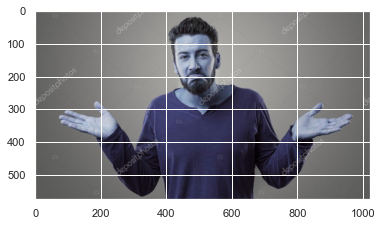

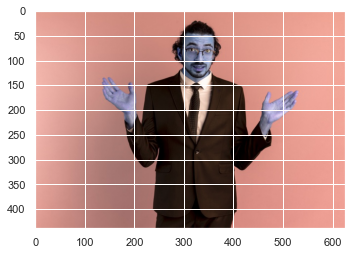

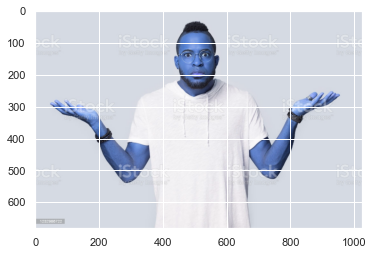

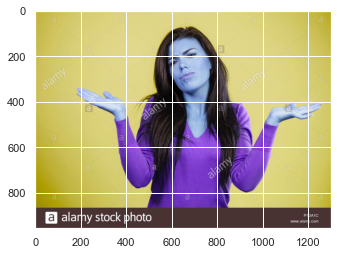

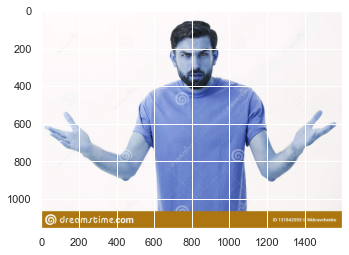

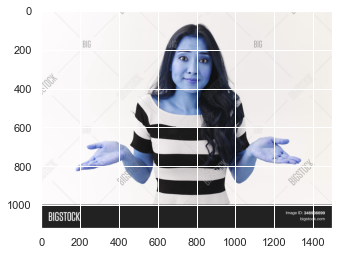

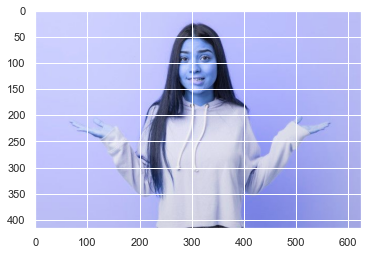

In [10]:
testimages = {name: cv2.imread(name) for name in glob.glob('./Images\imtestsamples/*jpg')}
LLEVideoArrayTest = []
for name, image in testimages.items():
    plt.figure()
    plt.imshow(image)
    print(name)   
#     cv2.imshow('image',image)
#     cv2.waitKey(0)s
    normalized_X_coordinates, normalized_Y_coordinates = get_ten_joints(image)
    print("normalized_X_coordinates = ", normalized_X_coordinates)
    print("normalized_Y_coordinates = ", normalized_Y_coordinates)
    LLEVideoArrayTest.append([normalized_X_coordinates, normalized_Y_coordinates])

In [11]:
for k in range(len(LLEVideoArrayTest)):
    temp = []
    for i in range(len(LLEVideoArrayTest[k][0])):
        temp.append(LLEVideoArrayTest[k][0][i])
        temp.append(LLEVideoArrayTest[k][1][i])           
    LLEFrames.append(temp)
print(LLEFrames)

[[-3.359994141662374, -52.12860262912253, 0.0, 0.0, 28.26364443023154, 24.581267664083846, -21.80330915019867, 27.48169328855431, 39.93959417368503, 133.94079542913926, -23.860618123348722, 128.88124455576357, -5.954259737057889, 101.65123953649649, -5.906477855875137, 9.987417888264405, 23.32287419666635, 175.15440349993497, -11.214934257750816, 176.840413936042], [-1.6482894308865073, -49.350560162247724, 0.0, 0.0, 25.478429091162983, 20.58595529123515, -24.966619908809662, 19.555829853570767, 30.248492606915537, 126.79196325670772, -24.946913495659828, 115.24146845360764, -12.149062869139016, 102.44679425944801, -7.343390840105713, -5.459656084285057, 14.65752145741135, 170.6611491051041, -17.035572067834437, 167.71936086045596], [-0.24794960158995483, -46.313237457375266, 0.0, 0.0, 25.125425094845646, 20.338835891004628, -25.1131344800708, 19.422016780413877, 35.09058897522674, 120.64250907348713, -24.164784811008943, 110.4815274633038, -1.098772712137514, 119.7927418179537, 1.5031

In [12]:
from sklearn import manifold, datasets
LLEReducedTest, err = manifold.locally_linear_embedding(LLEFrames, n_neighbors=20, n_components=2)
print("Done. Reconstruction error: %g" % err)
# imageNames = [name for name, image in images.items()]
# imagesArray = [np.array(cv2.imread(name)) for name, image in images.items()]
# names = []
# for i in imageNames:
#     print(name)
#     names.append(i.split("\\")[-1])
#     print(imageNames)

Done. Reconstruction error: 2.12748e-06


In [13]:
print(len(LLEReduced))

33


In [14]:
print(len(LLEReducedTest))

77


In [15]:
print(label)

[0 0 0 0 2 1 2 1 1 2 2 1 1 2 2 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1]


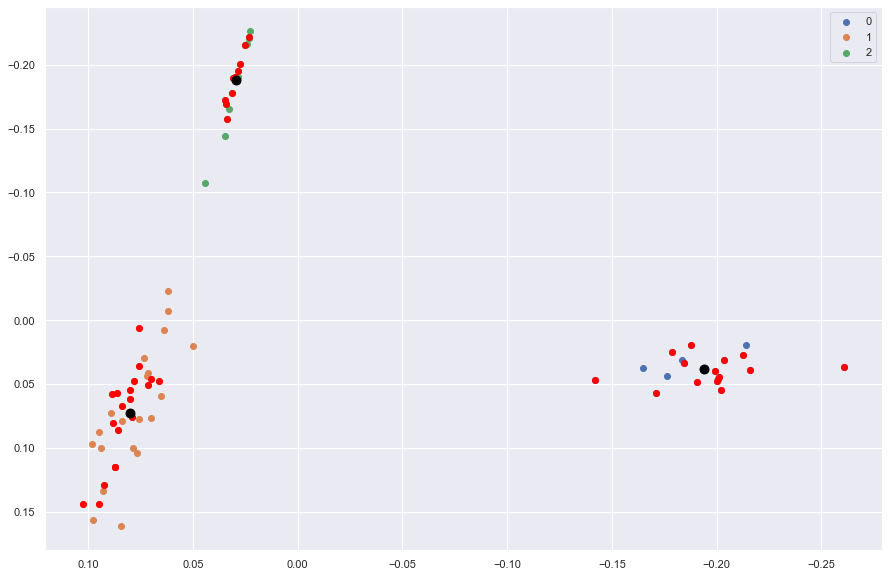

In [16]:
from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters = 3)

#predict the labels of clusters.
label = kmeans.fit_predict(LLEReducedTest)
 
#Getting unique labels
u_labels = np.unique(label)
centroids = kmeans.cluster_centers_

#plotting the results:
plt.figure(figsize=(15,10))
plt.gca().invert_yaxis()
for i in u_labels:
#     plt.scatter(LLEReducedTest[:-1][label == i , 0] , LLEReducedTest[:-1][label == i , 1] , label = i)
    plt.scatter(LLEReducedTest[:][label == i , 0] , LLEReducedTest[:][label == i , 1] , label = i)
for i in range(0,44):
    plt.scatter(LLEReducedTest[-i][0] , LLEReducedTest[-i][1], color='red')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'black')
plt.legend()
plt.gca().invert_xaxis()
plt.show()

In [17]:
dict = {2: 'idle',
        0: 'chin scrathc',
        1: 'shrugging'}
dict_count = {}
for i in range(0,44):
    y_pred = kmeans.predict([LLEReducedTest[-i]])
    print("The test image belongs to the cluster:", dict[y_pred[0]])
    if (dict[y_pred[0]]) in dict_count:
        dict_count[dict[y_pred[0]]] += 1
    else:
        dict_count[dict[y_pred[0]]] = 1

The test image belongs to the cluster: chin scrathc
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image belongs to the cluster: shrugging
The test image be

In [18]:
print(dict_count)

{'chin scrathc': 15, 'shrugging': 19, 'idle': 10}
